# This Notebook presents the results for the **_parametric method_**.

### Régularité mensuelle TGV par liaisons

#### https://data.sncf.com/explore/dataset/regularite-mensuelle-tgv-aqst/information/?sort=periode

In [80]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

fichier="regularite-mensuelle-tgv-aqst.csv"

#df = pandas.read_csv(fichier,sep=";")
df=pandas.read_table(fichier,sep=";")
df=df.sort_values(by=[df.columns[0] , df.columns[1]])

df.head(5)  #  afficher les 5 premières lignes

,Année,Mois,Service,Gare de départ,Gare d'arrivée,Durée moyenne du trajet (min),Nombre de circulations prévues,Nombre de trains annulés,Commentaire (facultatif) annulations,Nombre de trains en retard au départ,...,Retard moyen trains en retard > 15min,Nombre trains en retard > 30min,Nombre trains en retard > 60min,Période,Retard pour causes externes,Retard à cause infrastructure ferroviaire,Retard à cause gestion trafic,Retard à cause matériel roulant,Retard à cause gestion en gare et réutilisation de matériel,Retard à cause prise en compte voyageurs
334,2015,1.0,National,PARIS LYON,NIMES,177.905956,320.0,1.0,NaN,18.0,...,44.045455,12.0,6.0,2015-01,41.935484,19.354839,12.903226,9.677419,12.903226,3.225806
335,2015,1.0,National,PARIS EST,REIMS,47.173709,213.0,0.0,NaN,12.0,...,28.833333,2.0,0.0,2015-01,11.764706,17.647059,23.529412,23.529412,11.764706,11.764706
336,2015,1.0,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,192.349282,210.0,1.0,NaN,3.0,...,54.000000,5.0,4.0,2015-01,14.285714,71.428571,14.285714,0.000000,0.000000,0.000000
337,2015,1.0,National,PARIS MONTPARNASSE,VANNES,200.582386,177.0,1.0,NaN,3.0,...,25.666667,2.0,0.0,2015-01,44.444444,33.333333,11.111111,0.000000,11.111111,0.000000
338,2015,1.0,National,NANTES,STRASBOURG,327.038462,39.0,0.0,NaN,0.0,...,46.666667,3.0,0.0,2015-01,66.666667,0.000000,0.000000,33.333333,0.000000,0.000000


In [81]:
def melange_gaussien(loi1,loi2,p1,p2):
    """
    Creates the mixture of Gaussians.
    
    Params:
    =======
        lo1 = loi2 (function): here Normal distribution
        p1 = 1-p2 (float): 
    """
    res = []
    for i in range(len(loi1)):
        res.append(p1*loi1[i]+p2*loi2[i])
    return res

def normal(x, mu_, sigma_):
    """
    Normal distribution
    """
    return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)


def log_vraisemblance(data,mu1, mu2, sigma_,k):
    """
    Compute the log likelihood
    
    Params:
    =======
        data (array_like)
        mu1, mu2, sigma_ (float): estimated parameter of the model.
        k (int): rupture point
    """
    sums =  -1/(2*sigma_**2)*np.sum((data[:k] - mu1)**2) - 1/(2*sigma_**2) * np.sum((data[k:] - mu2)**2)
    return sums

def rupture(data):
    """
    Finds the rupture points
    
    Params:
    =======
        data (array_like)
    """
    logv_ = []
    sigma_ = np.std(data)
    n = len(data)
    for k in range(2,n-1):
        mu1 = np.mean(data[:k])
        mu2 = np.mean(data[k:])
        if ((mu1!=0) & (mu2 != 0)):
            log_ = log_vraisemblance(data,mu1,mu2,sigma_,k)
            logv_.append(log_)
    kmax = (np.where(logv_ == max(logv_))[0])[0]
    return [kmax,np.mean(data[:kmax]),np.mean(data[kmax:]),sigma_]

In [82]:
def Etat(gare,nom, colonne):
    rupt = rupture(gare[colonne].to_numpy())
    P1 = [normal(j,rupt[1],rupt[3]) for j in range(int(max(gare[colonne].values)+1))]
    P2 = [normal(j,rupt[2],rupt[3]) for j in range(int(max(gare[colonne].values)+1))]
    print(rupt)
    print(np.mean(gare[colonne].values))
    p1 = rupt[0]/gare[colonne].shape[0]
    print('p1:{}'.format(p1))
    p2 = 1 - p1
    print('p2:{}'.format(p2))
    
    print("k_rupture = ", rupt[0])
    print(nom, " : ", colonne)
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')

    l1 = [k for k in range(rupt[0])]
    l2 = [k for k in range(rupt[0],len(gare[colonne].values))]

    plt.plot(l1,gare[colonne].values[:rupt[0]], color = 'green')
    plt.plot(l2,gare[colonne].values[rupt[0]:], color = 'blue')
    plt.axvline(x=rupt[0],color='red')
    plt.show()

    print(nom, " : ", colonne)
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)

    # cacher les cadres : haut , droit et gauche
    ax1.spines['right'].set_visible(False)
    #ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')
    #ax1.set_yticks([])

    plt.hist(gare[colonne].values,color=np.random.rand(3),density =True,bins=30)

    plt.plot(P1,color='g')
    plt.plot(P2,color='b')
    plt.plot(p1*np.array(P1)+p2*np.array(P2), color ='r')
    plt.show()

In [83]:
def etat_gare(gare,nom):
    """
    Plots results for both column of interest.
    """
    gare_1=gare
    Etat(gare_1,nom,'Nombre de trains annulés')
    Etat(gare_1,nom,'Nombre de circulations prévues')



## Paris Lyon

[37, 55.37837837837838, 288.0, 398.8532326280213]
142.11864406779662
p1:0.6271186440677966
p2:0.3728813559322034
k_rupture =  37
PARIS LYON  :  Nombre de trains annulés


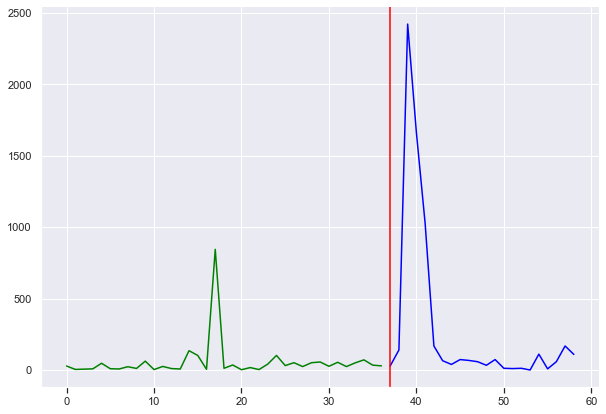

PARIS LYON  :  Nombre de trains annulés


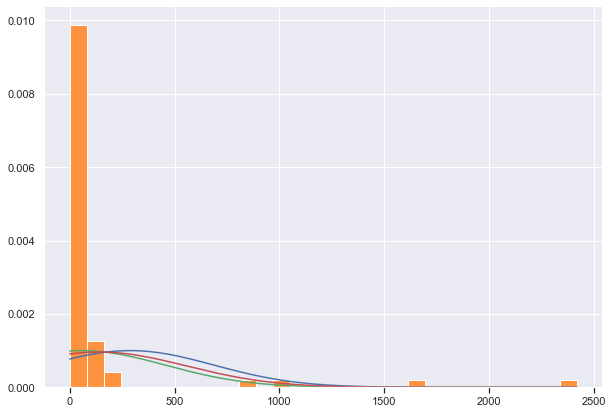

[27, 6224.037037037037, 6391.125, 319.7208851678682]
6314.661016949152
p1:0.4576271186440678
p2:0.5423728813559322
k_rupture =  27
PARIS LYON  :  Nombre de circulations prévues


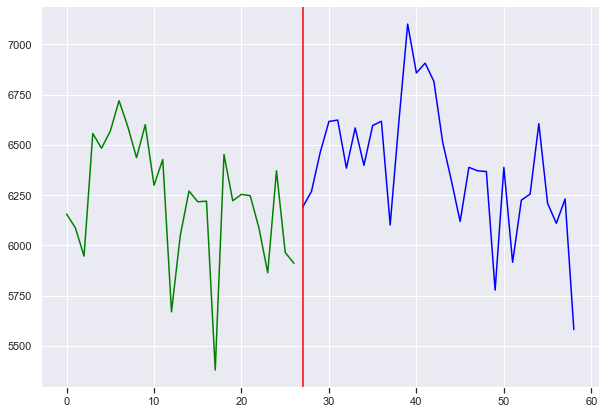

PARIS LYON  :  Nombre de circulations prévues


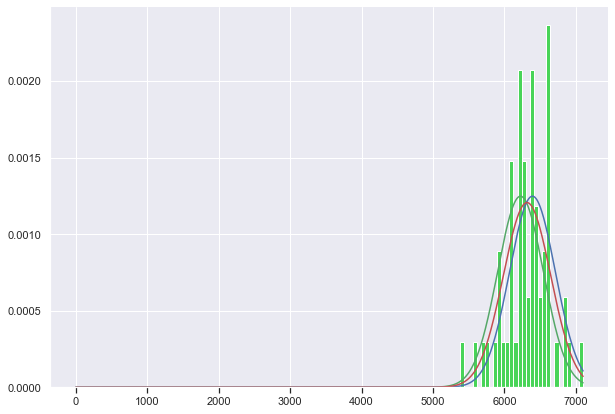

In [84]:
gare=df[df['Gare de départ']=='PARIS LYON']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS LYON')


In [89]:
def plot_likelihood(data):
    """
    Compute the log likelihood and plot.
    
    Params:
    =======
        data (array_like): the time series data
    """

    n = len(data)
    # dbar = sum(d)/float(n)
    dbar = np.mean(data)

    # dsbar = sum (d*d)/float(n)
    dsbar = np.mean(np.multiply(data,data))

    fac = dsbar-np.square(dbar)

    summ = 0
    summup = []

    for z in range(n):
        summ+=data[z]
        summup.append(summ)

    y = []

    for m in range(n-1):
        pos=m+1
        mscale = 4*(pos)*(n-pos)
        Q = summup[m]-(summ-summup[m])
        U = -np.square(dbar*(n-2*pos) + Q)/float(mscale) + fac
        y.append(-(n/float(2)-1)*np.log(n*U/2) - 0.5*np.log((pos*(n-pos))))

    z, zz = np.max(y), np.argmax(y)

    mean1 = sum(data[:zz+1])/float(len(data[:zz+1]))
    mean2=sum(data[(zz+1):n])/float(n-1-zz)

    return y, zz, mean1, mean2



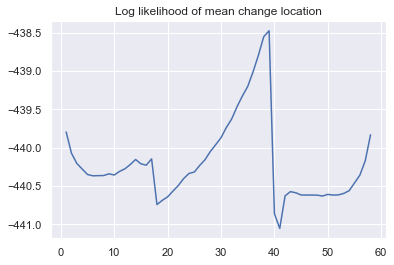

In [90]:
step_like = plot_likelihood(test['Nombre de trains annulés'])

years = range(0, len(test['Nombre de trains annulés']))

step_series = pandas.Series(step_like[0],index=years[1:])

step_series.plot(title='Log likelihood of mean change location')

## Paris Est

[29, 9.137931034482758, 47.13333333333333, 63.32973222902449]
28.45762711864407
p1:0.4915254237288136
p2:0.5084745762711864
k_rupture =  29
PARIS EST  :  Nombre de trains annulés


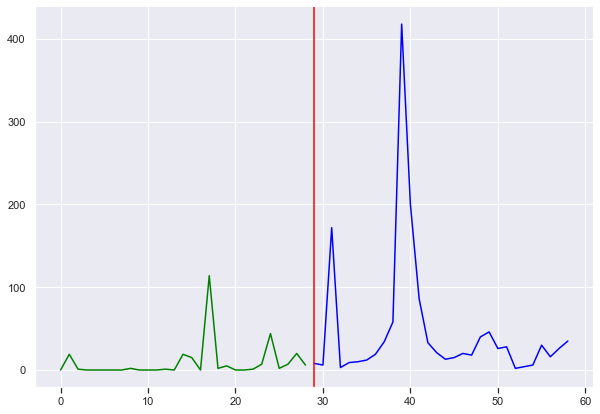

PARIS EST  :  Nombre de trains annulés


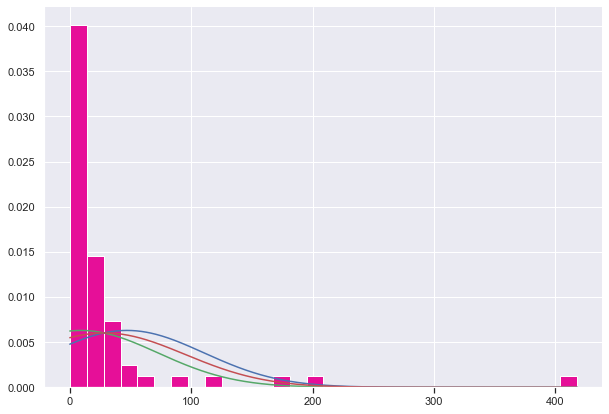

[16, 1434.75, 1589.6511627906978, 106.22118954745686]
1547.6440677966102
p1:0.2711864406779661
p2:0.728813559322034
k_rupture =  16
PARIS EST  :  Nombre de circulations prévues


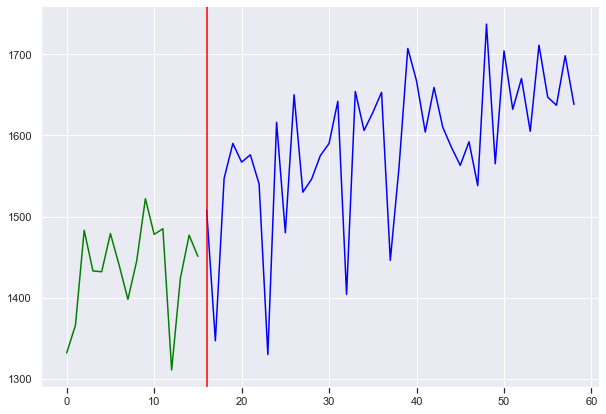

PARIS EST  :  Nombre de circulations prévues


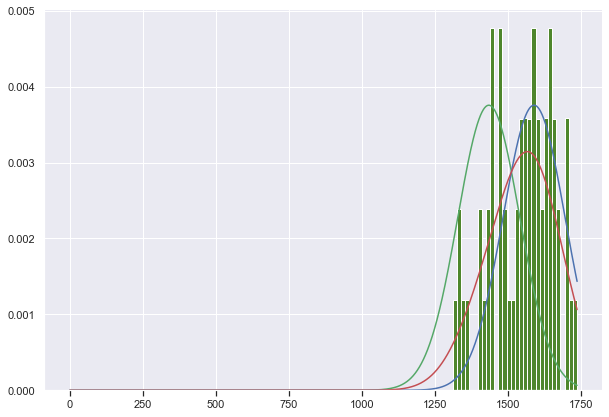

In [91]:
gare=df[df['Gare de départ']=='PARIS EST']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS EST')


## PARIS MONTPARNASSE

[35, 50.114285714285714, 257.0, 324.7184350343151]
134.27118644067798
p1:0.5932203389830508
p2:0.4067796610169492
k_rupture =  35
PARIS MONTPARNASSE  :  Nombre de trains annulés


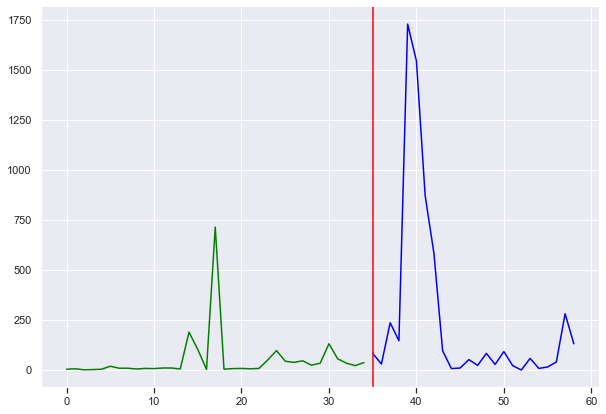

PARIS MONTPARNASSE  :  Nombre de trains annulés


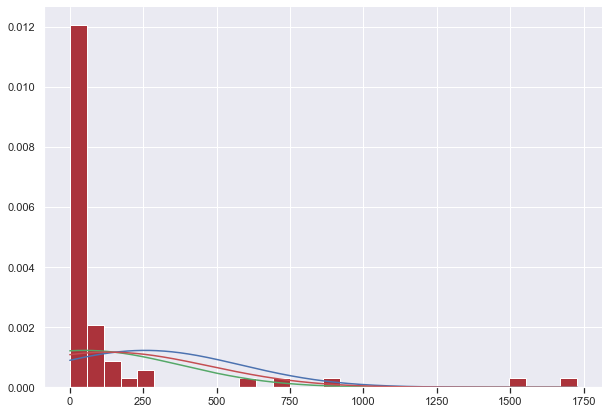

[27, 5251.925925925926, 5465.90625, 280.1339565476333]
5367.983050847458
p1:0.4576271186440678
p2:0.5423728813559322
k_rupture =  27
PARIS MONTPARNASSE  :  Nombre de circulations prévues


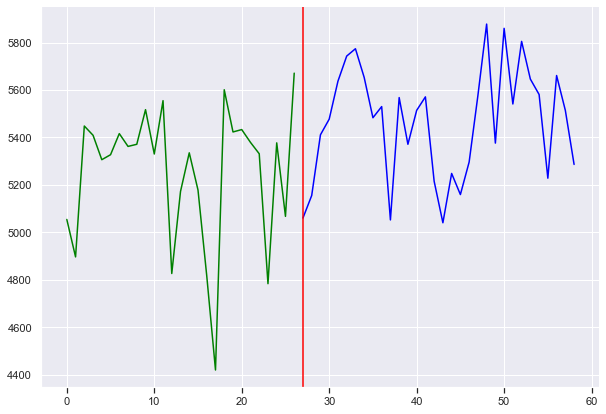

PARIS MONTPARNASSE  :  Nombre de circulations prévues


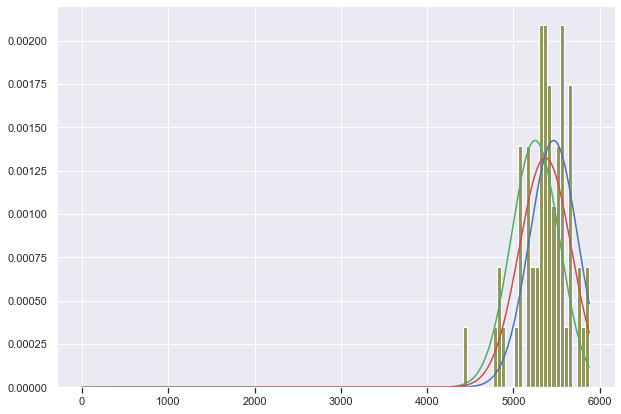

In [92]:
gare=df[df['Gare de départ']=='PARIS MONTPARNASSE']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS MONTPARNASSE')

# LYON PART DIEU

[37, 20.81081081081081, 145.3181818181818, 148.93296626369673]
67.23728813559322
p1:0.6271186440677966
p2:0.3728813559322034
k_rupture =  37
LYON PART DIEU  :  Nombre de trains annulés


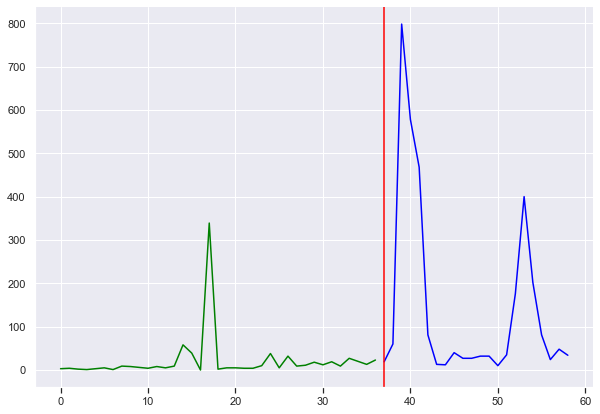

LYON PART DIEU  :  Nombre de trains annulés


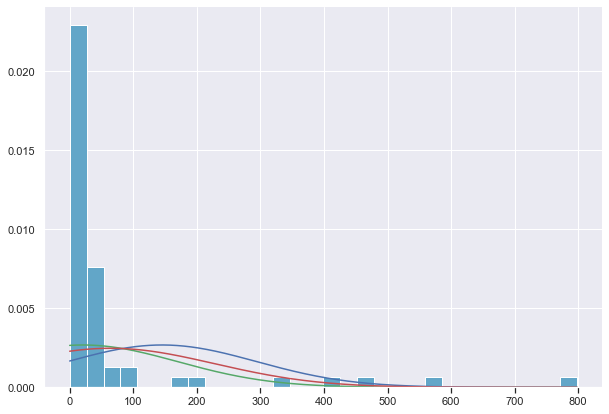

[53, 1907.132075471698, 1815.1666666666667, 158.69938192574634]
1897.7796610169491
p1:0.8983050847457628
p2:0.10169491525423724
k_rupture =  53
LYON PART DIEU  :  Nombre de circulations prévues


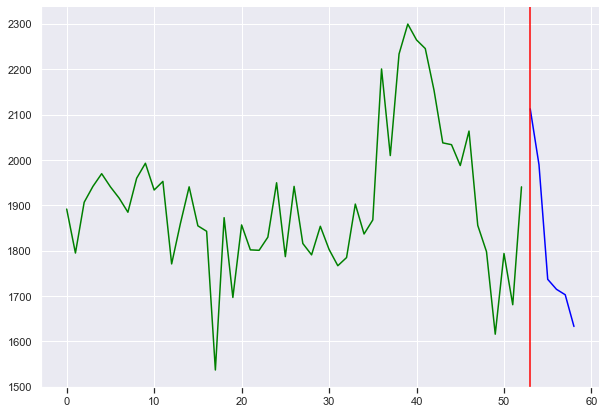

LYON PART DIEU  :  Nombre de circulations prévues


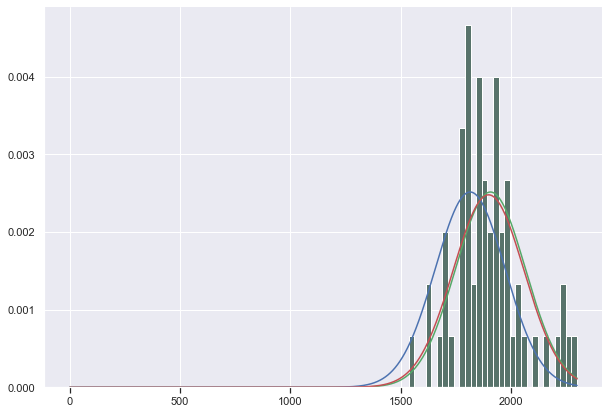

In [93]:
gare=df[df['Gare de départ']=='LYON PART DIEU']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'LYON PART DIEU')

# MARSEILLES SAINT CHARLES

[37, 12.45945945945946, 78.72727272727273, 91.35127814314106]
37.16949152542373
p1:0.6271186440677966
p2:0.3728813559322034
k_rupture =  37
MARSEILLE ST CHARLES  :  Nombre de trains annulés


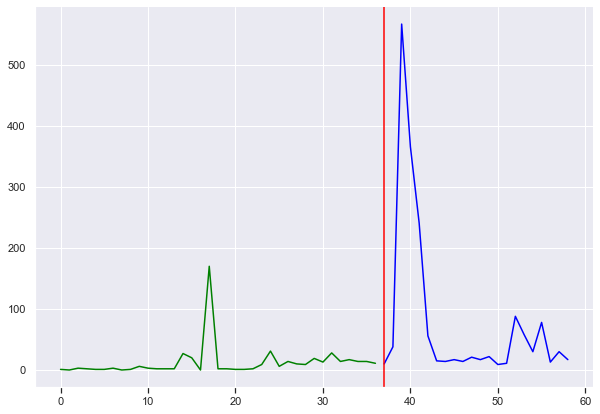

MARSEILLE ST CHARLES  :  Nombre de trains annulés


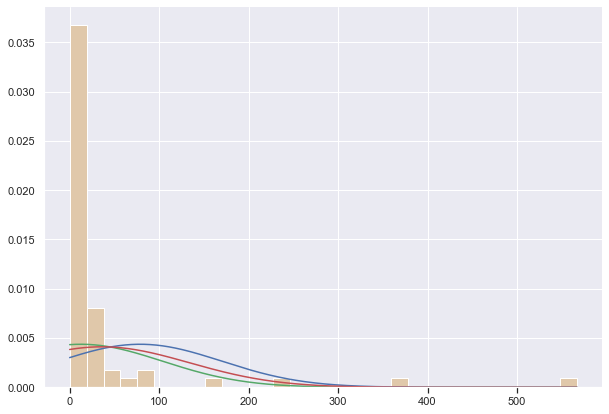

[34, 1159.1176470588234, 1402.6, 155.97523171992185]
1262.2881355932204
p1:0.576271186440678
p2:0.423728813559322
k_rupture =  34
MARSEILLE ST CHARLES  :  Nombre de circulations prévues


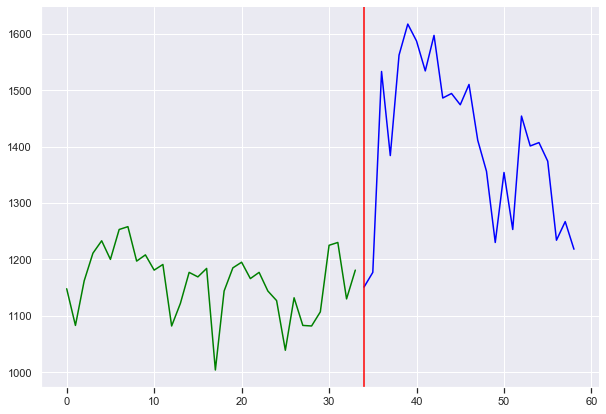

MARSEILLE ST CHARLES  :  Nombre de circulations prévues


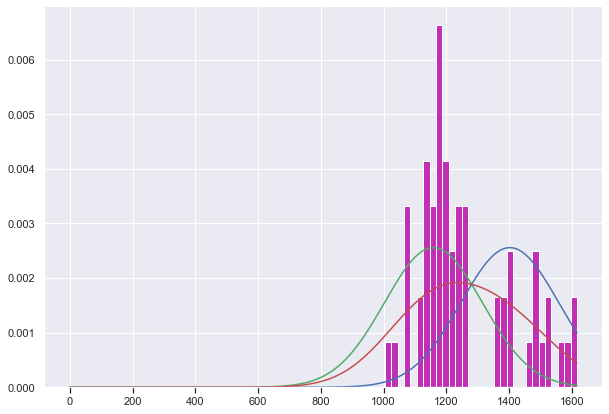

In [94]:
gare=df[df['Gare de départ']=='MARSEILLE ST CHARLES']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'MARSEILLE ST CHARLES')

# PARIS NORD

[35, 10.028571428571428, 80.54166666666667, 101.53267001106016]
38.71186440677966
p1:0.5932203389830508
p2:0.4067796610169492
k_rupture =  35
PARIS NORD  :  Nombre de trains annulés


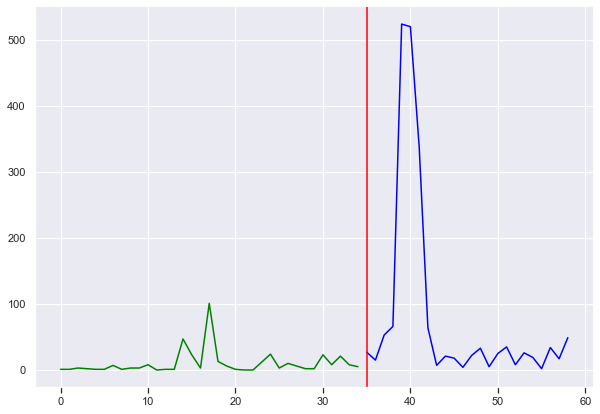

PARIS NORD  :  Nombre de trains annulés


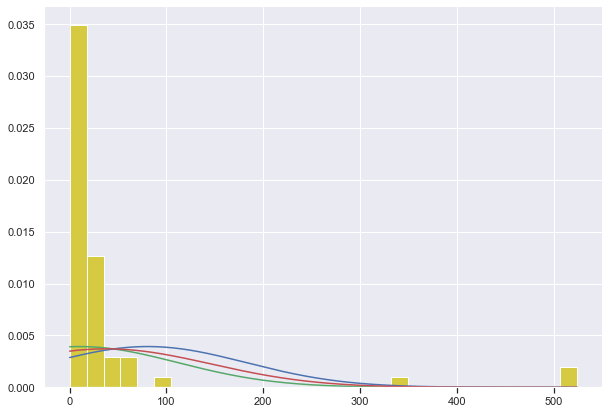

[22, 1293.2272727272727, 1322.7027027027027, 106.09925810815199]
1311.7118644067796
p1:0.3728813559322034
p2:0.6271186440677966
k_rupture =  22
PARIS NORD  :  Nombre de circulations prévues


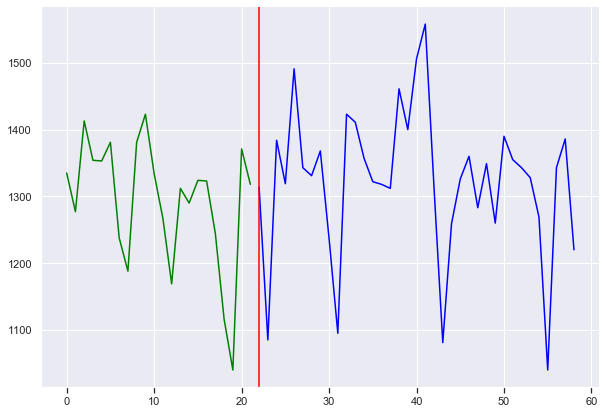

PARIS NORD  :  Nombre de circulations prévues


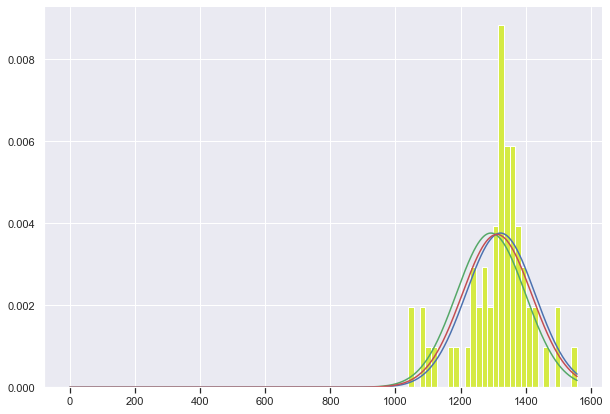

In [95]:
gare=df[df['Gare de départ']=='PARIS NORD']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS NORD')

# LILLE

[36, 6.972222222222222, 55.95652173913044, 63.357972598207745]
26.06779661016949
p1:0.6101694915254238
p2:0.38983050847457623
k_rupture =  36
LILLE  :  Nombre de trains annulés


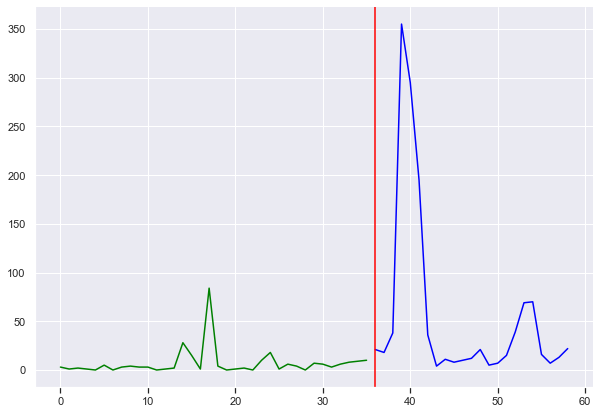

LILLE  :  Nombre de trains annulés


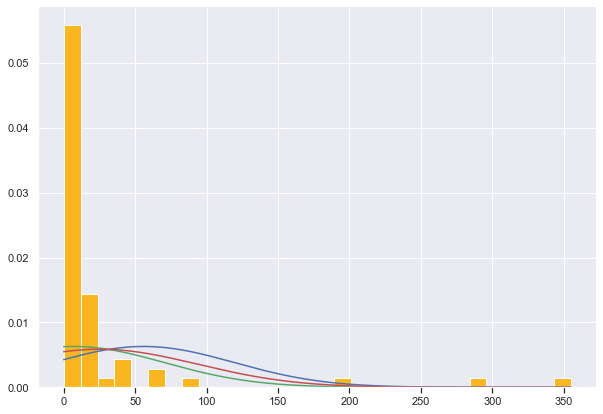

[41, 1033.6341463414635, 1006.9444444444445, 61.4558882400051]
1025.4915254237287
p1:0.6949152542372882
p2:0.30508474576271183
k_rupture =  41
LILLE  :  Nombre de circulations prévues


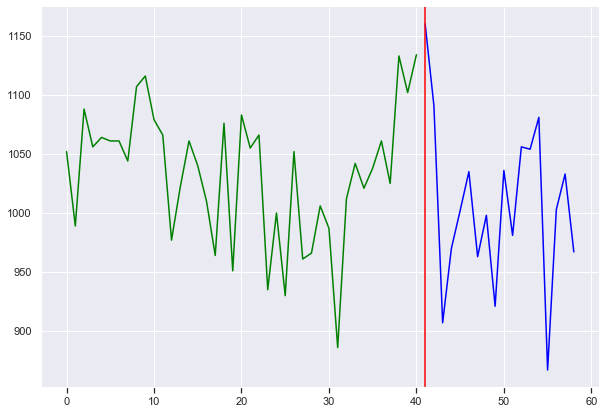

LILLE  :  Nombre de circulations prévues


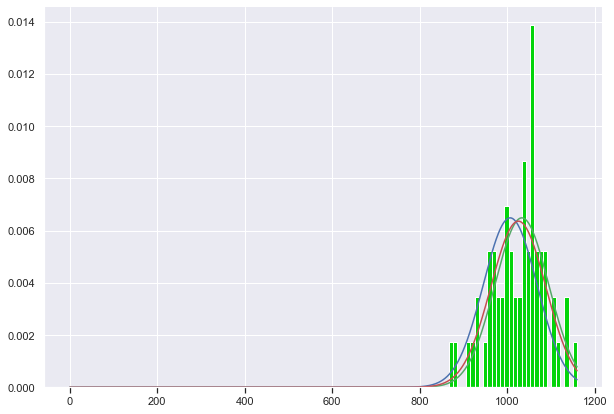

In [96]:
gare=df[df['Gare de départ']=='LILLE']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'LILLE')